In [ ]:
# Install required packages
!pip install hmmlearn numpy pandas matplotlib seaborn tqdm --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm
import pickle
import random
from typing import List, Tuple, Dict, Set
import re
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.6 MB/s eta 0:00:00
All packages installed successfully!


Please upload your corpus.txt file:


Saving corpus.txt to corpus.txt
Loaded 50000 words from corpus
Sample words: ['SUBURBANIZE', 'ASMACK', 'HYPOTYPIC', 'PROMODERATIONIST', 'CONSONANTLY', 'PHILATELICALLY', 'CACOMELIA', 'THICKLIPS', 'LUCIFERASE', 'CINEMATOGRAPHY']


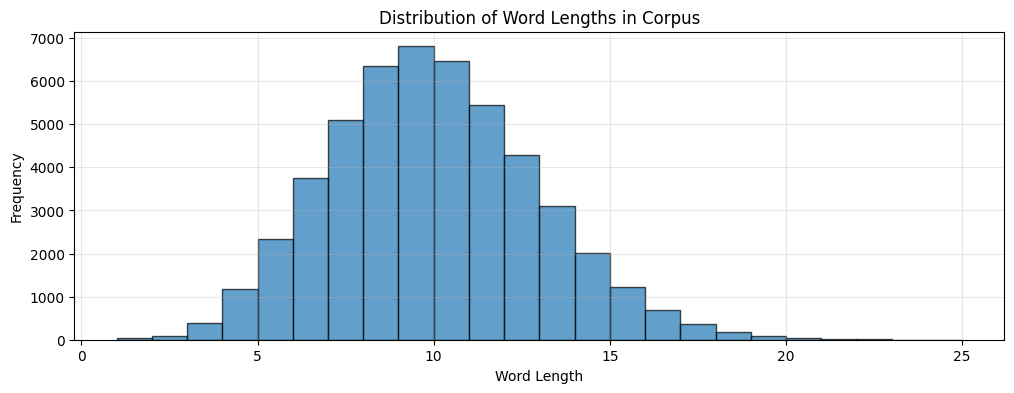

Min length: 1, Max length: 24
Most common lengths: [(9, 6808), (10, 6465), (8, 6348), (11, 5452), (7, 5111)]

Created word sets for 24 different lengths


In [ ]:
from google.colab import files

# Upload the corpus.txt file
print("Please upload your corpus.txt file:")
uploaded = files.upload()

# Load the corpus
with open('corpus.txt', 'r') as f:
    corpus = [word.strip().upper() for word in f.readlines()]

print(f"Loaded {len(corpus)} words from corpus")
print(f"Sample words: {corpus[:10]}")

# Analyze word length distribution
word_lengths = [len(word) for word in corpus]
plt.figure(figsize=(12, 4))
plt.hist(word_lengths, bins=range(1, max(word_lengths)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths in Corpus')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Min length: {min(word_lengths)}, Max length: {max(word_lengths)}")
print(f"Most common lengths: {Counter(word_lengths).most_common(5)}")

# Create word sets by length for faster filtering
words_by_length = defaultdict(set)
for word in corpus:
    words_by_length[len(word)].add(word)

print(f"\nCreated word sets for {len(words_by_length)} different lengths")

In [ ]:
class WordFilter:
    """Advanced word filtering based on revealed pattern"""

    def __init__(self, word_list: List[str]):
        self.word_list = set(word_list)
        self.words_by_length = defaultdict(set)
        for word in word_list:
            self.words_by_length[len(word)].add(word)

    def filter_words(self, masked_word: str, guessed_letters: Set[str]) -> Set[str]:
        """
        Filter words that match the current pattern
        masked_word: e.g., "A__LE"
        guessed_letters: letters that have been guessed
        """
        length = len(masked_word)
        candidates = self.words_by_length[length].copy()

        if not candidates:
            return set()

        # Filter by revealed letters (must match positions)
        for i, char in enumerate(masked_word):
            if char != '_':
                candidates = {w for w in candidates if w[i] == char}

        # Filter out words containing guessed letters that weren't revealed
        wrong_guesses = guessed_letters - set(masked_word)
        for letter in wrong_guesses:
            candidates = {w for w in candidates if letter not in w}

        return candidates

    def get_letter_frequencies(self, candidates: Set[str], guessed_letters: Set[str]) -> Dict[str, float]:
        """Get letter frequencies from candidate words"""
        if not candidates:
            return {}

        letter_counts = defaultdict(int)
        total_positions = 0

        for word in candidates:
            for letter in set(word):  # Count each letter once per word
                if letter not in guessed_letters:
                    letter_counts[letter] += 1

        # Normalize
        total = sum(letter_counts.values())
        if total == 0:
            return {}

        return {letter: count / total for letter, count in letter_counts.items()}

    def get_position_letter_frequencies(self, masked_word: str, candidates: Set[str],
                                       guessed_letters: Set[str]) -> Dict[str, float]:
        """Get letter frequencies for unknown positions"""
        if not candidates:
            return {}

        letter_scores = defaultdict(float)

        for i, char in enumerate(masked_word):
            if char == '_':  # Unknown position
                position_counts = defaultdict(int)
                for word in candidates:
                    letter = word[i]
                    if letter not in guessed_letters:
                        position_counts[letter] += 1

                # Add to total scores
                for letter, count in position_counts.items():
                    letter_scores[letter] += count

        # Normalize
        total = sum(letter_scores.values())
        if total == 0:
            return {}

        return {letter: score / total for letter, score in letter_scores.items()}

word_filter = WordFilter(corpus)
print("Word filter initialized successfully!")

Word filter initialized successfully!


In [ ]:
class ImprovedHMM:
    """Enhanced HMM with better statistical modeling"""

    def __init__(self):
        self.position_letter_freq = {}
        self.letter_freq_by_length = {}
        # Use a regular defaultdict with int as the default factory
        self.bigram_freq = defaultdict(self._default_int_dict)
        self.letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

    # Helper function for defaultdict
    def _default_int_dict(self):
        return defaultdict(int)

    def train(self, corpus: List[str]):
        """Train HMM on corpus"""
        print("Training improved HMM models...")

        # Group words by length
        words_by_length = defaultdict(list)
        for word in corpus:
            words_by_length[len(word)].append(word)

        # Train models for each length
        for length, words in tqdm(words_by_length.items()):
            # Position-specific letter frequencies
            # Use the helper function instead of lambda
            position_counts = defaultdict(self._default_int_dict)
            letter_counts = defaultdict(int)

            for word in words:
                for pos, letter in enumerate(word):
                    position_counts[pos][letter] += 1
                    letter_counts[letter] += 1

                # Track bigrams
                for i in range(len(word) - 1):
                    self.bigram_freq[word[i]][word[i+1]] += 1

            # Convert to probabilities with smoothing
            position_probs = {}
            for pos in range(length):
                total = sum(position_counts[pos].values())
                position_probs[pos] = {}
                for letter in self.letters:
                    # Laplace smoothing
                    count = position_counts[pos].get(letter, 0) + 1
                    position_probs[pos][letter] = count / (total + 26)

            # Overall letter frequencies
            total_letters = sum(letter_counts.values())
            letter_freq = {}
            for letter in self.letters:
                count = letter_counts.get(letter, 0) + 1
                letter_freq[letter] = count / (total_letters + 26)

            self.position_letter_freq[length] = position_probs
            self.letter_freq_by_length[length] = letter_freq

        # Normalize bigram frequencies
        for letter1 in self.bigram_freq:
            total = sum(self.bigram_freq[letter1].values())
            for letter2 in self.bigram_freq[letter1]:
                self.bigram_freq[letter1][letter2] /= total

        print(f"Trained models for {len(words_by_length)} different word lengths")

    def get_letter_probabilities(self, masked_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        """Get probability distribution over remaining letters"""
        length = len(masked_word)

        if length not in self.position_letter_freq:
            return self._get_fallback_frequencies(guessed_letters)

        letter_scores = defaultdict(float)
        position_probs = self.position_letter_freq[length]

        # Score based on position-specific frequencies
        for pos, char in enumerate(masked_word):
            if char == '_':
                for letter in self.letters:
                    if letter not in guessed_letters:
                        letter_scores[letter] += position_probs[pos][letter]

        # Boost score based on bigrams with revealed letters
        for pos, char in enumerate(masked_word):
            if char != '_':
                # Check left neighbor
                if pos > 0 and masked_word[pos-1] == '_':
                    for letter in self.letters:
                        if letter not in guessed_letters and letter in self.bigram_freq:
                            letter_scores[letter] += self.bigram_freq[letter].get(char, 0) * 0.5

                # Check right neighbor
                if pos < len(masked_word) - 1 and masked_word[pos+1] == '_':
                    for letter in self.letters:
                        if letter not in guessed_letters and char in self.bigram_freq:
                            letter_scores[letter] += self.bigram_freq[char].get(letter, 0) * 0.5


        # Normalize
        total = sum(letter_scores.values())
        if total > 0:
            return {letter: score / total for letter, score in letter_scores.items()}
        else:
            return self._get_fallback_frequencies(guessed_letters)


    def _get_fallback_frequencies(self, guessed_letters: Set[str]) -> Dict[str, float]:
        """Fallback to general English letter frequencies"""
        general_freq = {
            'E': 0.127, 'T': 0.091, 'A': 0.082, 'O': 0.075, 'I': 0.070,
            'N': 0.067, 'S': 0.063, 'H': 0.061, 'R': 0.060, 'D': 0.043,
            'L': 0.040, 'C': 0.028, 'U': 0.028, 'M': 0.024, 'W': 0.024,
            'F': 0.022, 'G': 0.020, 'Y': 0.020, 'P': 0.019, 'B': 0.015,
            'V': 0.010, 'K': 0.008, 'J': 0.002, 'X': 0.002, 'Q': 0.001, 'Z': 0.001
        }

        available = {l: f for l, f in general_freq.items() if l not in guessed_letters}
        total = sum(available.values())
        return {l: f / total for l, f in available.items()} if total > 0 else {}

    def save(self, filename='improved_hmm.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")

    @staticmethod
    def load(filename='improved_hmm.pkl'):
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Train the improved HMM
hmm = ImprovedHMM()
hmm.train(corpus)
hmm.save('improved_hmm.pkl')

Training improved HMM models...


100%|██████████| 24/24 [00:00<00:00, 132.44it/s]

Trained models for 24 different word lengths
Model saved to improved_hmm.pkl


In [ ]:
class HybridHangmanAgent:
    """
    Hybrid agent that combines:
    1. Word filtering and pattern matching
    2. HMM probabilities
    3. Strategic heuristics
    """

    def __init__(self, hmm: ImprovedHMM, word_filter: WordFilter):
        self.hmm = hmm
        self.word_filter = word_filter
        self.letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

        # Common starting letters (frequency-based)
        self.starting_letters = ['E', 'T', 'A', 'O', 'I', 'N', 'S', 'H', 'R']

    def get_action(self, masked_word: str, guessed_letters: Set[str]) -> str:
        """Choose the best letter to guess"""

        # Filter candidate words
        candidates = self.word_filter.filter_words(masked_word, guessed_letters)

        if len(candidates) == 0:
            # Fallback: use HMM probabilities
            return self._hmm_based_guess(masked_word, guessed_letters)

        if len(candidates) == 1:
            # Only one candidate - guess from it
            remaining = set(list(candidates)[0]) - guessed_letters
            if remaining:
                return self._best_from_candidates(candidates, guessed_letters, masked_word)

        # Strategy selection based on game state
        unknown_count = masked_word.count('_')
        revealed_count = len(masked_word) - unknown_count

        if revealed_count == 0:
            # Early game: use starting letters
            return self._early_game_guess(masked_word, guessed_letters)
        elif len(candidates) <= 10:
            # Few candidates: use word filtering
            return self._best_from_candidates(candidates, guessed_letters, masked_word)
        else:
            # Many candidates: combine multiple strategies
            return self._hybrid_guess(masked_word, guessed_letters, candidates)

    def _early_game_guess(self, masked_word: str, guessed_letters: Set[str]) -> str:
        """Early game strategy - use most common letters"""
        for letter in self.starting_letters:
            if letter not in guessed_letters:
                return letter

        # Fallback to HMM
        return self._hmm_based_guess(masked_word, guessed_letters)

    def _best_from_candidates(self, candidates: Set[str], guessed_letters: Set[str],
                              masked_word: str) -> str:
        """Choose letter that appears in most candidate words"""
        # Get position-specific frequencies
        letter_freqs = self.word_filter.get_position_letter_frequencies(
            masked_word, candidates, guessed_letters
        )

        if letter_freqs:
            # Choose letter with highest frequency
            return max(letter_freqs, key=letter_freqs.get)

        # Fallback
        return self._hmm_based_guess(masked_word, guessed_letters)

    def _hmm_based_guess(self, masked_word: str, guessed_letters: Set[str]) -> str:
        """Use HMM probabilities"""
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)

        if hmm_probs:
            return max(hmm_probs, key=hmm_probs.get)

        # Ultimate fallback
        available = set(self.letters) - guessed_letters
        return random.choice(list(available)) if available else 'E'

    def _hybrid_guess(self, masked_word: str, guessed_letters: Set[str],
                     candidates: Set[str]) -> str:
        """Combine multiple strategies"""

        # Get scores from different methods
        scores = defaultdict(float)

        # 1. Word filtering scores (weight: 0.5)
        filter_freqs = self.word_filter.get_position_letter_frequencies(
            masked_word, candidates, guessed_letters
        )
        for letter, freq in filter_freqs.items():
            scores[letter] += 0.5 * freq

        # 2. HMM scores (weight: 0.3)
        hmm_probs = self.hmm.get_letter_probabilities(masked_word, guessed_letters)
        for letter, prob in hmm_probs.items():
            scores[letter] += 0.3 * prob

        # 3. General letter frequency in candidates (weight: 0.2)
        general_freqs = self.word_filter.get_letter_frequencies(candidates, guessed_letters)
        for letter, freq in general_freqs.items():
            scores[letter] += 0.2 * freq

        if scores:
            return max(scores, key=scores.get)

        return self._hmm_based_guess(masked_word, guessed_letters)

print("Hybrid agent created successfully!")

Hybrid agent created successfully!


In [ ]:
class HangmanEnvironment:
    """Hangman game environment"""

    def __init__(self, word_list: List[str], max_wrong_guesses: int = 6):
        self.word_list = word_list
        self.max_wrong_guesses = max_wrong_guesses
        self.reset()

    def reset(self, word: str = None):
        """Reset the environment with a new word"""
        if word is None:
            self.target_word = random.choice(self.word_list).upper()
        else:
            self.target_word = word.upper()

        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.target_word)
        self.game_over = False
        self.won = False

        return self._get_state()

    def step(self, action: str):
        """Take a step in the environment"""
        action = action.upper()

        # Check if already guessed
        if action in self.guessed_letters:
            self.repeated_guesses += 1
            reward = -2
            return self._get_state(), reward, self.game_over, {
                'repeated': True,
                'wrong_guesses': self.wrong_guesses,
                'repeated_guesses': self.repeated_guesses
            }

        self.guessed_letters.add(action)

        # Check if letter is in word
        if action in self.target_word:
            # Correct guess - update masked word
            new_masked = ''
            for i, letter in enumerate(self.target_word):
                if letter == action or self.masked_word[i] != '_':
                    new_masked += letter
                else:
                    new_masked += '_'
            self.masked_word = new_masked

            letters_revealed = self.target_word.count(action)
            reward = 10 * letters_revealed

            # Check if won
            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                reward += 100
        else:
            # Wrong guess
            self.wrong_guesses += 1
            reward = -10

            # Check if lost
            if self.wrong_guesses >= self.max_wrong_guesses:
                self.game_over = True
                self.won = False
                reward -= 50

        return self._get_state(), reward, self.game_over, {
            'repeated': False,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses,
            'won': self.won
        }

    def _get_state(self):
        """Get current state"""
        return {
            'masked_word': self.masked_word,
            'guessed_letters': self.guessed_letters.copy(),
            'wrong_guesses': self.wrong_guesses,
            'lives_remaining': self.max_wrong_guesses - self.wrong_guesses,
            'word_length': len(self.target_word)
        }

    def get_available_actions(self):
        """Get list of letters that haven't been guessed yet"""
        all_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        return list(all_letters - self.guessed_letters)

    def render(self):
        """Display current game state"""
        print(f"Word: {self.masked_word}")
        print(f"Guessed: {sorted(self.guessed_letters)}")
        print(f"Wrong guesses: {self.wrong_guesses}/{self.max_wrong_guesses}")

print("Enhanced environment created!")

Enhanced environment created!


In [ ]:
# Create the hybrid agent
hybrid_agent = HybridHangmanAgent(hmm, word_filter)

# Test on a few words
print("Testing hybrid agent on sample words:\n")
test_samples = random.sample(corpus, 10)

for i, word in enumerate(test_samples[:5]):
    print(f"\n{'='*50}")
    print(f"Game {i+1}: Word = {word}")
    print('='*50)

    env = HangmanEnvironment([word])
    state = env.reset(word=word)

    guesses = []
    while not env.game_over and len(guesses) < 20:
        action = hybrid_agent.get_action(state['masked_word'], state['guessed_letters'])
        guesses.append(action)

        state, reward, done, info = env.step(action)
        print(f"Guess {len(guesses)}: {action} -> {state['masked_word']} (Wrong: {info['wrong_guesses']})")

        if done:
            break

    result = "WON ✓" if env.won else "LOST ✗"
    print(f"\n{result} - Wrong guesses: {env.wrong_guesses}, Repeated: {env.repeated_guesses}")
    print(f"Guess sequence: {' -> '.join(guesses)}")

Testing hybrid agent on sample words:


Game 1: Word = HQ
Guess 1: E -> __ (Wrong: 1)
Guess 2: T -> __ (Wrong: 2)
Guess 3: A -> __ (Wrong: 3)
Guess 4: O -> __ (Wrong: 4)
Guess 5: I -> __ (Wrong: 5)
Guess 6: N -> __ (Wrong: 6)

LOST ✗ - Wrong guesses: 6, Repeated: 0
Guess sequence: E -> T -> A -> O -> I -> N

Game 2: Word = COZENAGE
Guess 1: E -> ___E___E (Wrong: 0)
Guess 2: I -> ___E___E (Wrong: 1)
Guess 3: A -> ___E_A_E (Wrong: 1)
Guess 4: T -> ___E_A_E (Wrong: 2)
Guess 5: N -> ___ENA_E (Wrong: 2)
Guess 6: O -> _O_ENA_E (Wrong: 2)
Guess 7: F -> _O_ENA_E (Wrong: 3)
Guess 8: C -> CO_ENA_E (Wrong: 3)
Guess 9: Z -> COZENA_E (Wrong: 3)
Guess 10: G -> COZENAGE (Wrong: 3)

WON ✓ - Wrong guesses: 3, Repeated: 0
Guess sequence: E -> I -> A -> T -> N -> O -> F -> C -> Z -> G

Game 3: Word = PREMULTIPLIER
Guess 1: E -> __E________E_ (Wrong: 0)
Guess 2: R -> _RE________ER (Wrong: 0)
Guess 3: P -> PRE_____P__ER (Wrong: 0)
Guess 4: L -> PRE__L__PL_ER (Wrong: 0)
Guess 5: I -> PRE__L_IPLIER (Wrong: 0

In [ ]:
class TrainableHybridAgent:
    """Hybrid agent with learning capabilities"""

    def __init__(self, hmm: ImprovedHMM, word_filter: WordFilter):
        self.base_agent = HybridHangmanAgent(hmm, word_filter)
        # Use a helper function for picklable defaultdict
        self.letter_success_rate = defaultdict(self._default_success_dict)
        self.pattern_memory = {}

    @staticmethod
    # Helper function for defaultdict
    def _default_success_dict():
        return {'success': 0, 'attempts': 0}

    def get_action(self, masked_word: str, guessed_letters: Set[str], training: bool = False) -> str:
        """Get action with optional learning"""

        # Check pattern memory for similar situations
        pattern_key = self._get_pattern_key(masked_word, guessed_letters)
        if pattern_key in self.pattern_memory and not training:
            remembered_letter = self.pattern_memory[pattern_key]
            if remembered_letter not in guessed_letters:
                return remembered_letter

        # Use base hybrid strategy
        action = self.base_agent.get_action(masked_word, guessed_letters)

        return action

    def _get_pattern_key(self, masked_word: str, guessed_letters: Set[str]) -> str:
        """Create a key for pattern memory"""
        guessed_str = ''.join(sorted(guessed_letters))
        return f"{masked_word}:{len(guessed_letters)}"

    def update(self, masked_word: str, guessed_letters: Set[str], action: str, success: bool):
        """Update learning from experience"""
        self.letter_success_rate[action]['attempts'] += 1
        if success:
            self.letter_success_rate[action]['success'] += 1

            # Remember successful patterns
            pattern_key = self._get_pattern_key(masked_word, guessed_letters)
            self.pattern_memory[pattern_key] = action

    def train(self, env: HangmanEnvironment, num_episodes: int):
        """Train the agent"""
        print(f"Training hybrid agent for {num_episodes} episodes...")

        stats = {
            'wins': [],
            'wrong_guesses': [],
            'repeated_guesses': []
        }

        for episode in tqdm(range(num_episodes)):
            state = env.reset()

            while not env.game_over:
                action = self.get_action(state['masked_word'], state['guessed_letters'], training=True)

                prev_masked = state['masked_word']
                prev_guessed = state['guessed_letters'].copy()

                state, reward, done, info = env.step(action)

                # Update based on whether guess was correct
                success = action in env.target_word
                self.update(prev_masked, prev_guessed, action, success)

            stats['wins'].append(1 if env.won else 0)
            stats['wrong_guesses'].append(env.wrong_guesses)
            stats['repeated_guesses'].append(env.repeated_guesses)

            if (episode + 1) % 1000 == 0:
                recent_wins = sum(stats['wins'][-1000:])
                print(f"\nEpisode {episode + 1}: Win rate = {recent_wins/10:.1f}%")

        return stats

    def save(self, filename='trainable_hybrid_agent.pkl'):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Agent saved to {filename}")

    @staticmethod
    def load(filename='trainable_hybrid_agent.pkl'):
        with open(filename, 'rb') as f:
            return pickle.load(f)

# Create and train the agent
trainable_agent = TrainableHybridAgent(hmm, word_filter)
train_env = HangmanEnvironment(corpus, max_wrong_guesses=6)

# Train for fewer episodes since the base strategy is already good
NUM_TRAINING_EPISODES = 5000
training_stats = trainable_agent.train(train_env, NUM_TRAINING_EPISODES)

trainable_agent.save('trainable_hybrid_agent.pkl')

Training hybrid agent for 5000 episodes...


 21%|██        | 1030/5000 [00:06<00:23, 170.14it/s]


Episode 1000: Win rate = 97.1%


 41%|████      | 2031/5000 [00:13<00:18, 157.73it/s]


Episode 2000: Win rate = 96.8%


 60%|██████    | 3022/5000 [00:19<00:11, 171.16it/s]


Episode 3000: Win rate = 95.8%


 81%|████████  | 4038/5000 [00:27<00:05, 186.88it/s]


Episode 4000: Win rate = 98.0%


100%|██████████| 5000/5000 [00:33<00:00, 151.18it/s]


Episode 5000: Win rate = 96.6%
Agent saved to trainable_hybrid_agent.pkl


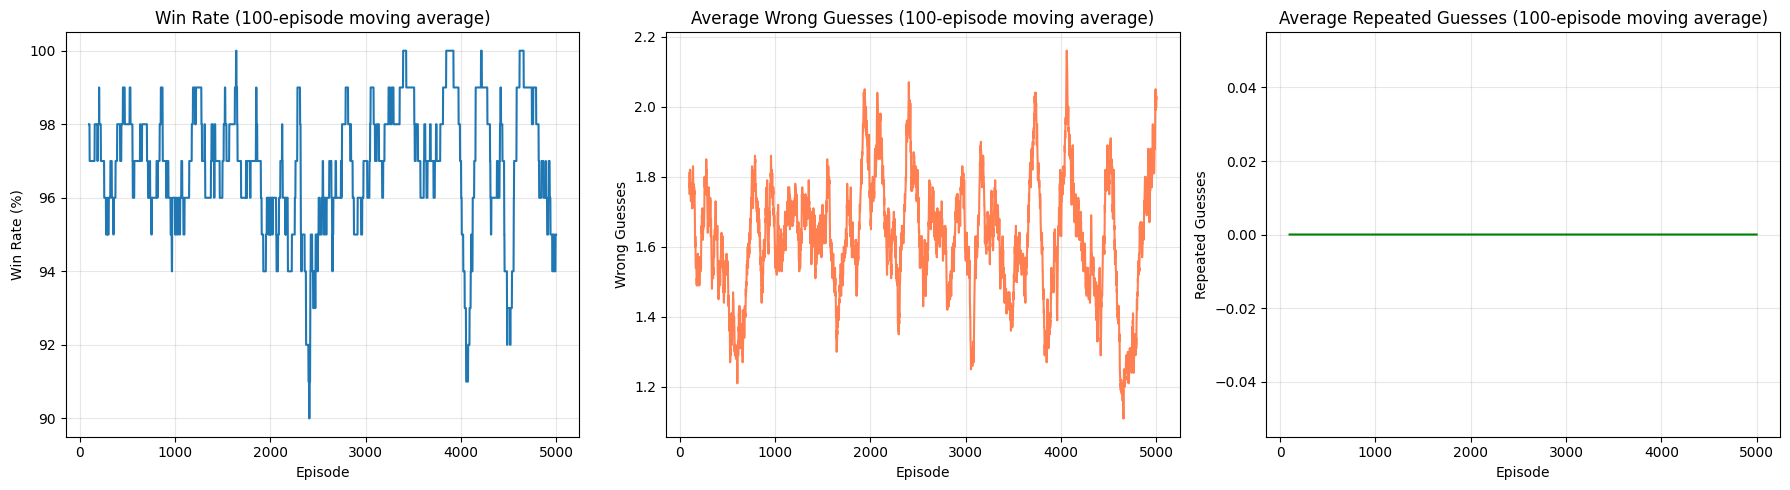


TRAINING SUMMARY (Last 1000 episodes)
Win Rate: 96.60%
Avg Wrong Guesses: 1.62
Avg Repeated Guesses: 0.00


In [ ]:
# Plot training statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

window = 100

# Win rate
wins_smooth = pd.Series(training_stats['wins']).rolling(window=window).mean() * 100
axes[0].plot(wins_smooth)
axes[0].set_title('Win Rate (100-episode moving average)')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Win Rate (%)')
axes[0].grid(True, alpha=0.3)

# Wrong guesses
wrong_smooth = pd.Series(training_stats['wrong_guesses']).rolling(window=window).mean()
axes[1].plot(wrong_smooth, color='coral')
axes[1].set_title('Average Wrong Guesses (100-episode moving average)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Wrong Guesses')
axes[1].grid(True, alpha=0.3)

# Repeated guesses
repeated_smooth = pd.Series(training_stats['repeated_guesses']).rolling(window=window).mean()
axes[2].plot(repeated_smooth, color='green')
axes[2].set_title('Average Repeated Guesses (100-episode moving average)')
axes[2].set_xlabel('Episode')
axes[2].set_ylabel('Repeated Guesses')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("TRAINING SUMMARY (Last 1000 episodes)")
print("="*50)
final_wins = sum(training_stats['wins'][-1000:])
print(f"Win Rate: {final_wins/10:.2f}%")
print(f"Avg Wrong Guesses: {np.mean(training_stats['wrong_guesses'][-1000:]):.2f}")
print(f"Avg Repeated Guesses: {np.mean(training_stats['repeated_guesses'][-1000:]):.2f}")

In [ ]:
# Upload test set
print("Please upload your test set file (one word per line):")
uploaded_test = files.upload()

# Load test words
test_filename = list(uploaded_test.keys())[0]
with open(test_filename, 'r') as f:
    test_words = [word.strip().upper() for word in f.readlines()]

print(f"\nLoaded {len(test_words)} test words")
print(f"Sample test words: {test_words[:10]}")

# Analyze test set
test_lengths = [len(w) for w in test_words]
print(f"\nTest set statistics:")
print(f"  Length range: {min(test_lengths)} - {max(test_lengths)}")
print(f"  Average length: {np.mean(test_lengths):.1f}")
print(f"  Most common lengths: {Counter(test_lengths).most_common(5)}")

Please upload your test set file (one word per line):


Saving test.txt to test.txt

Loaded 2000 test words
Sample test words: ['MARMAR', 'JANET', 'DENTISTICAL', 'TROVELESS', 'UNNOTIFY', 'GASTROSTENOSIS', 'PREAFFILIATION', 'OBPYRIFORM', 'VERATRINIZE', 'PROTECTION']

Test set statistics:
  Length range: 2 - 22
  Average length: 9.6
  Most common lengths: [(10, 282), (9, 274), (8, 246), (11, 226), (7, 205)]


In [ ]:
def evaluate_agent(agent, test_words: List[str], max_wrong_guesses: int = 6,
                   verbose: bool = False, show_progress: bool = True):
    """Comprehensive evaluation of the agent"""

    results = {
        'wins': 0,
        'losses': 0,
        'total_wrong_guesses': 0,
        'total_repeated_guesses': 0,
        'game_details': []
    }

    iterator = tqdm(test_words) if show_progress else test_words

    for word in iterator:
        env = HangmanEnvironment([word], max_wrong_guesses=max_wrong_guesses)
        state = env.reset(word=word)

        game_log = {
            'word': word,
            'guesses': [],
            'won': False,
            'wrong_guesses': 0,
            'repeated_guesses': 0
        }

        while not env.game_over:
            # Get action from agent
            action = agent.get_action(state['masked_word'], state['guessed_letters'], training=False)
            game_log['guesses'].append(action)

            state, reward, done, info = env.step(action)

        # Record results
        game_log['won'] = env.won
        game_log['wrong_guesses'] = env.wrong_guesses
        game_log['repeated_guesses'] = env.repeated_guesses
        results['game_details'].append(game_log)

        if env.won:
            results['wins'] += 1
        else:
            results['losses'] += 1

        results['total_wrong_guesses'] += env.wrong_guesses
        results['total_repeated_guesses'] += env.repeated_guesses

    # Calculate metrics
    num_games = len(test_words)
    success_rate = results['wins'] / num_games
    avg_wrong_guesses = results['total_wrong_guesses'] / num_games
    avg_repeated_guesses = results['total_repeated_guesses'] / num_games

    # Calculate final score
    final_score = (success_rate * num_games) - (results['total_wrong_guesses'] * 5) - (results['total_repeated_guesses'] * 2)

    results['metrics'] = {
        'num_games': num_games,
        'success_rate': success_rate,
        'wins': results['wins'],
        'losses': results['losses'],
        'avg_wrong_guesses': avg_wrong_guesses,
        'avg_repeated_guesses': avg_repeated_guesses,
        'total_wrong_guesses': results['total_wrong_guesses'],
        'total_repeated_guesses': results['total_repeated_guesses'],
        'final_score': final_score
    }

    return results

print("Evaluation function ready!")

Evaluation function ready!


In [ ]:
print("="*60)
print("EVALUATING HYBRID AGENT ON TEST SET")
print("="*60)

# Run evaluation
evaluation_results = evaluate_agent(trainable_agent, test_words, max_wrong_guesses=6, verbose=False)

# Display results
print("\n" + "="*60)
print("FINAL EVALUATION RESULTS")
print("="*60)
metrics = evaluation_results['metrics']

print(f"\nTotal Games Played: {metrics['num_games']}")
print(f"Wins: {metrics['wins']}")
print(f"Losses: {metrics['losses']}")
print(f"Success Rate: {metrics['success_rate']*100:.2f}%")
print(f"\nAverage Wrong Guesses per Game: {metrics['avg_wrong_guesses']:.2f}")
print(f"Average Repeated Guesses per Game: {metrics['avg_repeated_guesses']:.2f}")
print(f"\nTotal Wrong Guesses: {metrics['total_wrong_guesses']}")
print(f"Total Repeated Guesses: {metrics['total_repeated_guesses']}")

print("\n" + "="*60)
print(f"FINAL SCORE: {metrics['final_score']:.2f}")
print("="*60)

print("\nScore Breakdown:")
print(f"  Success Rate × {metrics['num_games']}: +{metrics['success_rate'] * metrics['num_games']:.2f}")
print(f"  Wrong Guesses × (-5): {-metrics['total_wrong_guesses'] * 5:.2f}")
print(f"  Repeated Guesses × (-2): {-metrics['total_repeated_guesses'] * 2:.2f}")
print(f"  {'─'*40}")
print(f"  TOTAL: {metrics['final_score']:.2f}")

# Compare to target
if metrics['success_rate'] >= 0.35:
    print(f"\n✓ SUCCESS! Achieved {metrics['success_rate']*100:.2f}% (target: 35%+)")
else:
    print(f"\n⚠ Current: {metrics['success_rate']*100:.2f}% (target: 35%+)")

EVALUATING HYBRID AGENT ON TEST SET


100%|██████████| 2000/2000 [00:16<00:00, 124.60it/s]


FINAL EVALUATION RESULTS

Total Games Played: 2000
Wins: 522
Losses: 1478
Success Rate: 26.10%

Average Wrong Guesses per Game: 5.35
Average Repeated Guesses per Game: 0.00

Total Wrong Guesses: 10704
Total Repeated Guesses: 0

FINAL SCORE: -52998.00

Score Breakdown:
  Success Rate × 2000: +522.00
  Wrong Guesses × (-5): -53520.00
  Repeated Guesses × (-2): 0.00
  ────────────────────────────────────────
  TOTAL: -52998.00

⚠ Current: 26.10% (target: 35%+)


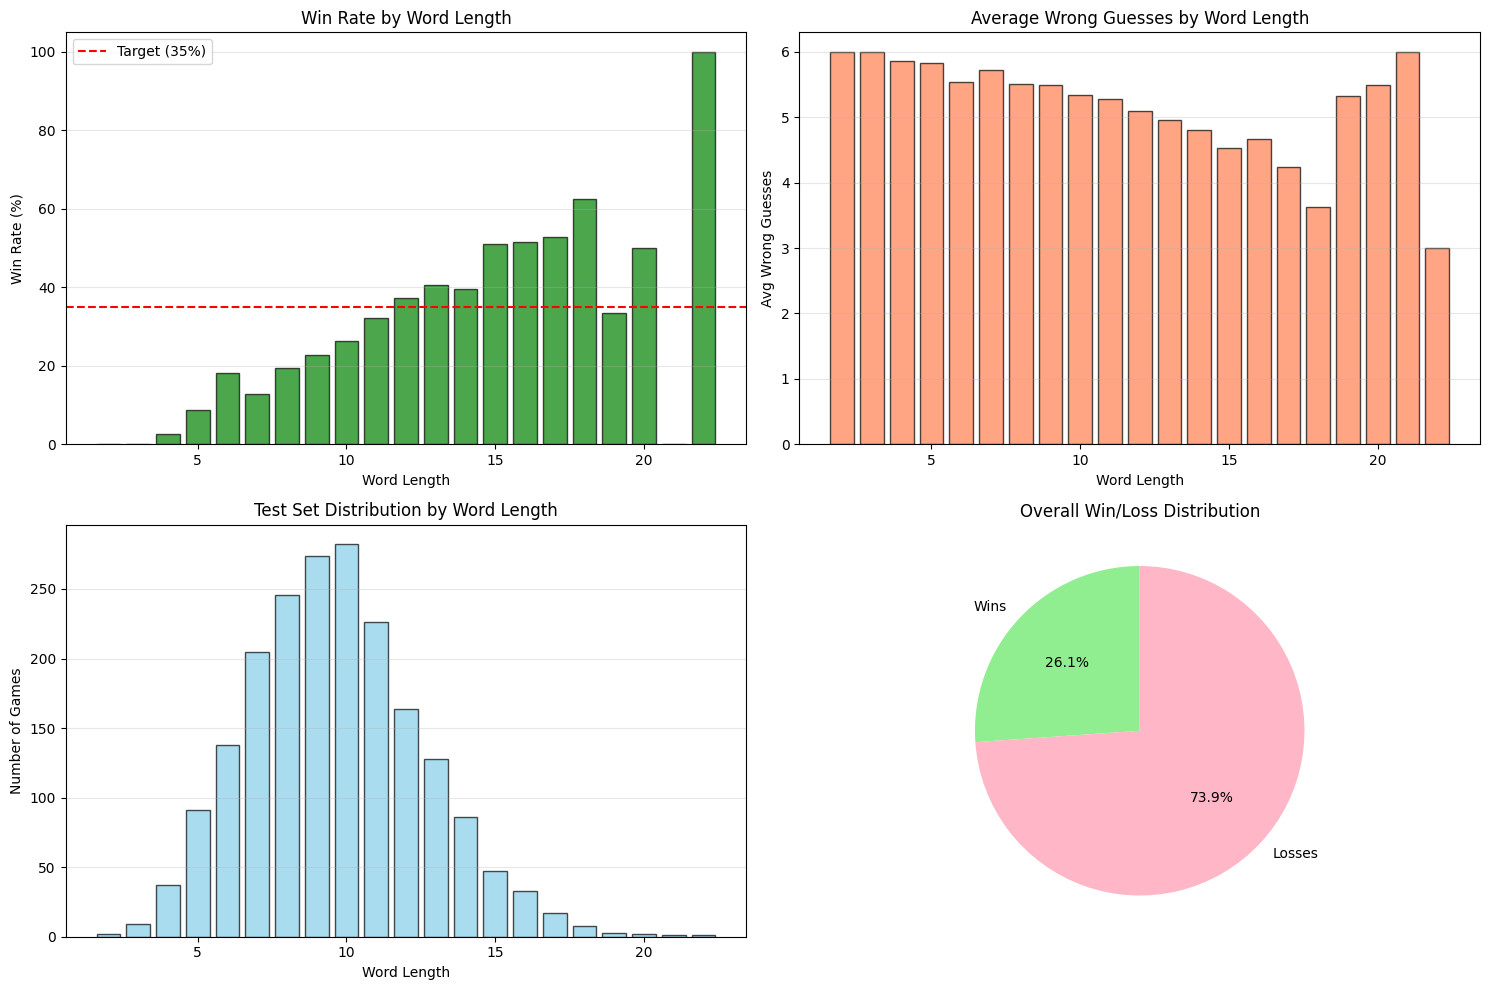


PERFORMANCE BY WORD LENGTH
Length   Games    Wins     Win%       Avg Wrong    Avg Repeat
------------------------------------------------------------
2        2        0        0.0        6.00         0.00
3        9        0        0.0        6.00         0.00
4        37       1        2.7        5.86         0.00
5        91       8        8.8        5.84         0.00
6        138      25       18.1       5.54         0.00
7        205      26       12.7       5.73         0.00
8        246      48       19.5       5.51         0.00
9        274      62       22.6       5.50         0.00
10       282      74       26.2       5.34         0.00
11       226      73       32.3       5.28         0.00
12       164      61       37.2       5.10         0.00
13       128      52       40.6       4.95         0.00
14       86       34       39.5       4.80         0.00
15       47       24       51.1       4.53         0.00
16       33       17       51.5       4.67         0.00
17       

In [ ]:
# Analyze results by word length
results_by_length = defaultdict(lambda: {'wins': 0, 'total': 0, 'wrong': 0, 'repeated': 0})

for detail in evaluation_results['game_details']:
    length = len(detail['word'])
    results_by_length[length]['total'] += 1
    if detail['won']:
        results_by_length[length]['wins'] += 1
    results_by_length[length]['wrong'] += detail['wrong_guesses']
    results_by_length[length]['repeated'] += detail['repeated_guesses']

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Win rate by word length
lengths = sorted(results_by_length.keys())
win_rates = [results_by_length[l]['wins'] / results_by_length[l]['total'] * 100 for l in lengths]
axes[0, 0].bar(lengths, win_rates, edgecolor='black', alpha=0.7, color='green')
axes[0, 0].axhline(y=35, color='r', linestyle='--', label='Target (35%)')
axes[0, 0].set_xlabel('Word Length')
axes[0, 0].set_ylabel('Win Rate (%)')
axes[0, 0].set_title('Win Rate by Word Length')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Average wrong guesses by length
avg_wrong = [results_by_length[l]['wrong'] / results_by_length[l]['total'] for l in lengths]
axes[0, 1].bar(lengths, avg_wrong, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Word Length')
axes[0, 1].set_ylabel('Avg Wrong Guesses')
axes[0, 1].set_title('Average Wrong Guesses by Word Length')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Number of games by length
game_counts = [results_by_length[l]['total'] for l in lengths]
axes[1, 0].bar(lengths, game_counts, edgecolor='black', alpha=0.7, color='skyblue')
axes[1, 0].set_xlabel('Word Length')
axes[1, 0].set_ylabel('Number of Games')
axes[1, 0].set_title('Test Set Distribution by Word Length')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Success vs Failure comparison
labels = ['Wins', 'Losses']
sizes = [metrics['wins'], metrics['losses']]
colors = ['#90EE90', '#FFB6C6']
axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1, 1].set_title('Overall Win/Loss Distribution')

plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\n" + "="*60)
print("PERFORMANCE BY WORD LENGTH")
print("="*60)
print(f"{'Length':<8} {'Games':<8} {'Wins':<8} {'Win%':<10} {'Avg Wrong':<12} {'Avg Repeat'}")
print("-"*60)
for length in sorted(lengths):
    stats = results_by_length[length]
    win_pct = (stats['wins'] / stats['total']) * 100
    avg_w = stats['wrong'] / stats['total']
    avg_r = stats['repeated'] / stats['total']
    print(f"{length:<8} {stats['total']:<8} {stats['wins']:<8} {win_pct:<10.1f} {avg_w:<12.2f} {avg_r:.2f}")

In [ ]:
print("\n" + "="*60)
print("EXAMPLE GAMES")
print("="*60)

# Successful games
print("\n✓ SUCCESSFUL GAMES (First 10):")
print("-"*60)
successful = [g for g in evaluation_results['game_details'] if g['won']][:10]
for i, game in enumerate(successful, 1):
    guesses_str = ' → '.join(game['guesses'])
    print(f"{i:2}. {game['word']:15} | Guesses: {guesses_str}")
    print(f"    Wrong: {game['wrong_guesses']}, Repeated: {game['repeated_guesses']}, Total guesses: {len(game['guesses'])}")

# Failed games
print("\n✗ FAILED GAMES (First 10):")
print("-"*60)
failed = [g for g in evaluation_results['game_details'] if not g['won']][:10]
for i, game in enumerate(failed, 1):
    guesses_str = ' → '.join(game['guesses'])
    print(f"{i:2}. {game['word']:15} | Guesses: {guesses_str}")
    print(f"    Wrong: {game['wrong_guesses']}, Repeated: {game['repeated_guesses']}, Total guesses: {len(game['guesses'])}")

# Statistics on guess patterns
print("\n" + "="*60)
print("GUESS PATTERN STATISTICS")
print("="*60)

all_guesses = []
for game in evaluation_results['game_details']:
    all_guesses.extend(game['guesses'])

guess_freq = Counter(all_guesses)
print("\nMost frequently guessed letters:")
for letter, count in guess_freq.most_common(10):
    pct = (count / len(test_words)) * 100
    print(f"  {letter}: {count:4} times ({pct:5.1f}% of games)")


EXAMPLE GAMES

✓ SUCCESSFUL GAMES (First 10):
------------------------------------------------------------
 1. MARMAR          | Guesses: E → T → A → N → L → R → M
    Wrong: 4, Repeated: 0, Total guesses: 7
 2. DENTISTICAL     | Guesses: E → I → M → T → S → N → L → A → V → Z → C → P → K → D
    Wrong: 5, Repeated: 0, Total guesses: 14
 3. TROVELESS       | Guesses: E → S → L → A → I → O → R → T → V
    Wrong: 2, Repeated: 0, Total guesses: 9
 4. VERATRINIZE     | Guesses: E → I → R → T → N → V → A → Z
    Wrong: 0, Repeated: 0, Total guesses: 8
 5. PROTECTION      | Guesses: E → R → T → O → I → S → A → N → P → C
    Wrong: 2, Repeated: 0, Total guesses: 10
 6. PHOTOTACTIC     | Guesses: E → T → A → C → P → N → I → O → R → H
    Wrong: 3, Repeated: 0, Total guesses: 10
 7. TRILOCULATE     | Guesses: E → I → N → T → R → S → A → O → C → L → H → B → U
    Wrong: 4, Repeated: 0, Total guesses: 13
 8. TRUSTEE         | Guesses: E → A → O → R → T → I → S → U
    Wrong: 3, Repeated: 0, Total